In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm
import os
os.getcwd()

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [2]:
csv_file = "F:\\multi-task-model\\dataset\\dataset.csv"
data = pd.read_csv(csv_file)

In [3]:
# Load and preprocess the image data
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    return image_array

In [4]:
data['species'].value_counts()

Mackerel    200
Sardine     200
Seer        200
Tuna        200
Name: species, dtype: int64

In [5]:
data['freshness'].value_counts()

Bad     400
Good    400
Name: freshness, dtype: int64

In [6]:
image_paths = data["image_path"]
species_labels = data["species"]
freshness_labels = data["freshness"]

# Split the dataset into training and validation sets
train_image_paths, validation_image_paths, train_species_labels, validation_species_labels, train_freshness_labels, validation_freshness_labels = train_test_split(
    image_paths, species_labels, freshness_labels, test_size=0.2, random_state=42)
validation_image_paths, test_image_paths, validation_species_labels, test_species_labels, validation_freshness_labels, test_freshness_labels = train_test_split(
    validation_image_paths, validation_species_labels, validation_freshness_labels, test_size=0.2, random_state=42)

In [7]:
test_data = {'image_paths': test_image_paths, 'species': test_species_labels, 'freshness': test_freshness_labels}
test_data = pd.DataFrame(test_data)

In [8]:
num_species_classes=4
num_freshness_classes=2

In [9]:
base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))


base_model.trainable = False
# freeze_layers_until = 200
# for layer in base_model.layers[:freeze_layers_until]:
#     layer.trainable = False

In [10]:
learning_rate = 0.001
batch_size = 16

In [11]:
inputs = keras.Input(shape=(224, 224, 3))

# Species
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

species_outputs = Dense(num_species_classes, activation="softmax", name="species_output")(x)

freshness_outputs = Dense(num_freshness_classes, activation="softmax", name="freshness_output")(x)




model = Model(inputs=base_model.input, outputs=[species_outputs, freshness_outputs])

In [13]:
class CombinedEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, metrics_to_monitor, patience=0, mode='min'):
        super(CombinedEarlyStopping, self).__init__()
        self.metrics_to_monitor = metrics_to_monitor
        self.patience = patience
        self.mode = mode
        self.wait = 0
        self.stopped_epoch = 0
        self.best_combined_metric = float('inf') if mode == 'min' else float('-inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        combined_metric = self._calculate_combined_metric(logs)
        if self._is_better(combined_metric, self.best_combined_metric):
            self.best_combined_metric = combined_metric
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True

    def _calculate_combined_metric(self, logs):
        combined_metric = 0.0
        for metric in self.metrics_to_monitor:
            if metric in logs:
                combined_metric += logs[metric]
        return combined_metric / len(self.metrics_to_monitor)

    def _is_better(self, metric_value, best_value):
        if self.mode == 'min':
            return metric_value < best_value
        elif self.mode == 'max':
            return metric_value > best_value
        else:
            raise ValueError("Invalid mode. Must be either 'min' or 'max'.")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping due to no improvement in combined loss for {self.stopped_epoch+1} epochs.")
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)
                print("Restored best model weights.")

metrics_to_monitor = ['val_species_output_loss', 'val_freshness_output_loss']

In [15]:
# multi_metrics_callback = MultiMetricsCallback(metrics_to_monitor,losses_to_monitor, checkpoint_path = 'best_combined.h5')
combined_early_stopping_callback = CombinedEarlyStopping(metrics_to_monitor, patience=20, mode='min')

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss={"species_output": "categorical_crossentropy", "freshness_output": "categorical_crossentropy"},
    metrics={"species_output": "accuracy", "freshness_output": "accuracy"},
)

In [17]:
epochs = 500

In [18]:
# Create training and validation generators
train_images = np.array([load_image(image_path) for image_path in tqdm(train_image_paths)])
validation_images = np.array([load_image(image_path) for image_path in tqdm(validation_image_paths)])
test_images = np.array([load_image(image_path) for image_path in tqdm(test_image_paths)])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


In [19]:
with open('train_images.pickle', 'wb') as file:
    pickle.dump(train_images, file)
with open('validation_images.pickle', 'wb') as file:
    pickle.dump(validation_images, file)
with open('test_images.pickle', 'wb') as file:
    pickle.dump(test_images, file)

In [20]:
with open('train_images.pickle', 'rb') as file:
    train_images = pickle.load(file)
with open('validation_images.pickle', 'rb') as file:
    validation_images = pickle.load(file)
with open('test_images.pickle', 'rb') as file:
    test_images = pickle.load(file)

In [21]:
# Encode species labels
species_label_encoder = LabelEncoder()
train_species_labels_encoded = species_label_encoder.fit_transform(train_species_labels)
validation_species_labels_encoded = species_label_encoder.transform(validation_species_labels)
# Encode freshness labels
freshness_label_encoder = LabelEncoder()
train_freshness_labels_encoded = freshness_label_encoder.fit_transform(train_freshness_labels)
validation_freshness_labels_encoded = freshness_label_encoder.transform(validation_freshness_labels)

with open('species_label_encoder.pkl', 'wb') as f:
    pickle.dump(species_label_encoder, f)
with open('freshness_label_encoder.pkl', 'wb') as f:
    pickle.dump(freshness_label_encoder, f)

In [22]:
# Convert labels to one-hot vectors
num_species_classes = len(species_label_encoder.classes_)
num_freshness_classes = len(freshness_label_encoder.classes_)
train_species_labels_onehot = keras.utils.to_categorical(train_species_labels_encoded, num_species_classes)
train_freshness_labels_onehot = keras.utils.to_categorical(train_freshness_labels_encoded, num_freshness_classes)
validation_species_labels_onehot = keras.utils.to_categorical(validation_species_labels_encoded, num_species_classes)
validation_freshness_labels_onehot = keras.utils.to_categorical(validation_freshness_labels_encoded, num_freshness_classes)

In [24]:
# Train the model
history=model.fit(
    train_images,
    [train_species_labels_onehot, train_freshness_labels_onehot],
    validation_data=(validation_images, [validation_species_labels_onehot, validation_freshness_labels_onehot]),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[combined_early_stopping_callback]
)

Epoch 1/500
40/40 [==============================] - 58s 1s/step - loss: 1.9176 - species_output_loss: 1.1060 - freshness_output_loss: 0.8116 - species_output_accuracy: 0.5312 - freshness_output_accuracy: 0.5984 - val_loss: 1.1716 - val_species_output_loss: 0.6798 - val_freshness_output_loss: 0.4918 - val_species_output_accuracy: 0.7031 - val_freshness_output_accuracy: 0.7109
Epoch 2/500
40/40 [==============================] - 45s 1s/step - loss: 1.3489 - species_output_loss: 0.6764 - freshness_output_loss: 0.6724 - species_output_accuracy: 0.7297 - freshness_output_accuracy: 0.6469 - val_loss: 0.9155 - val_species_output_loss: 0.4181 - val_freshness_output_loss: 0.4974 - val_species_output_accuracy: 0.7969 - val_freshness_output_accuracy: 0.7266
Epoch 3/500
40/40 [==============================] - 45s 1s/step - loss: 1.1796 - species_output_loss: 0.5633 - freshness_output_loss: 0.6164 - species_output_accuracy: 0.7609 - freshness_output_accuracy: 0.6828 - val_loss: 1.1573 - val_speci

Epoch 23/500
40/40 [==============================] - 46s 1s/step - loss: 0.4147 - species_output_loss: 0.0975 - freshness_output_loss: 0.3172 - species_output_accuracy: 0.9609 - freshness_output_accuracy: 0.8406 - val_loss: 0.4330 - val_species_output_loss: 0.1243 - val_freshness_output_loss: 0.3087 - val_species_output_accuracy: 0.9453 - val_freshness_output_accuracy: 0.8750
Epoch 24/500
40/40 [==============================] - 45s 1s/step - loss: 0.4150 - species_output_loss: 0.1202 - freshness_output_loss: 0.2948 - species_output_accuracy: 0.9578 - freshness_output_accuracy: 0.8719 - val_loss: 0.6482 - val_species_output_loss: 0.3373 - val_freshness_output_loss: 0.3109 - val_species_output_accuracy: 0.8906 - val_freshness_output_accuracy: 0.8438
Epoch 25/500
40/40 [==============================] - 47s 1s/step - loss: 0.4261 - species_output_loss: 0.1365 - freshness_output_loss: 0.2896 - species_output_accuracy: 0.9547 - freshness_output_accuracy: 0.8641 - val_loss: 0.4256 - val_sp

Epoch 45/500
40/40 [==============================] - 49s 1s/step - loss: 0.2380 - species_output_loss: 0.0812 - freshness_output_loss: 0.1568 - species_output_accuracy: 0.9656 - freshness_output_accuracy: 0.9281 - val_loss: 0.3618 - val_species_output_loss: 0.1017 - val_freshness_output_loss: 0.2601 - val_species_output_accuracy: 0.9609 - val_freshness_output_accuracy: 0.8672
Epoch 46/500
40/40 [==============================] - 48s 1s/step - loss: 0.2557 - species_output_loss: 0.0632 - freshness_output_loss: 0.1925 - species_output_accuracy: 0.9812 - freshness_output_accuracy: 0.9219 - val_loss: 0.3471 - val_species_output_loss: 0.0817 - val_freshness_output_loss: 0.2653 - val_species_output_accuracy: 0.9453 - val_freshness_output_accuracy: 0.8594
Epoch 47/500
40/40 [==============================] - 48s 1s/step - loss: 0.2215 - species_output_loss: 0.0474 - freshness_output_loss: 0.1742 - species_output_accuracy: 0.9828 - freshness_output_accuracy: 0.9250 - val_loss: 0.4071 - val_sp

Average species train accuracy: 0.9390904019985881
Average species Validation accuracy: 0.9340122767857143
Average species train loss: 0.47915723813431604
Average species Validation loss: 0.49134221619793345


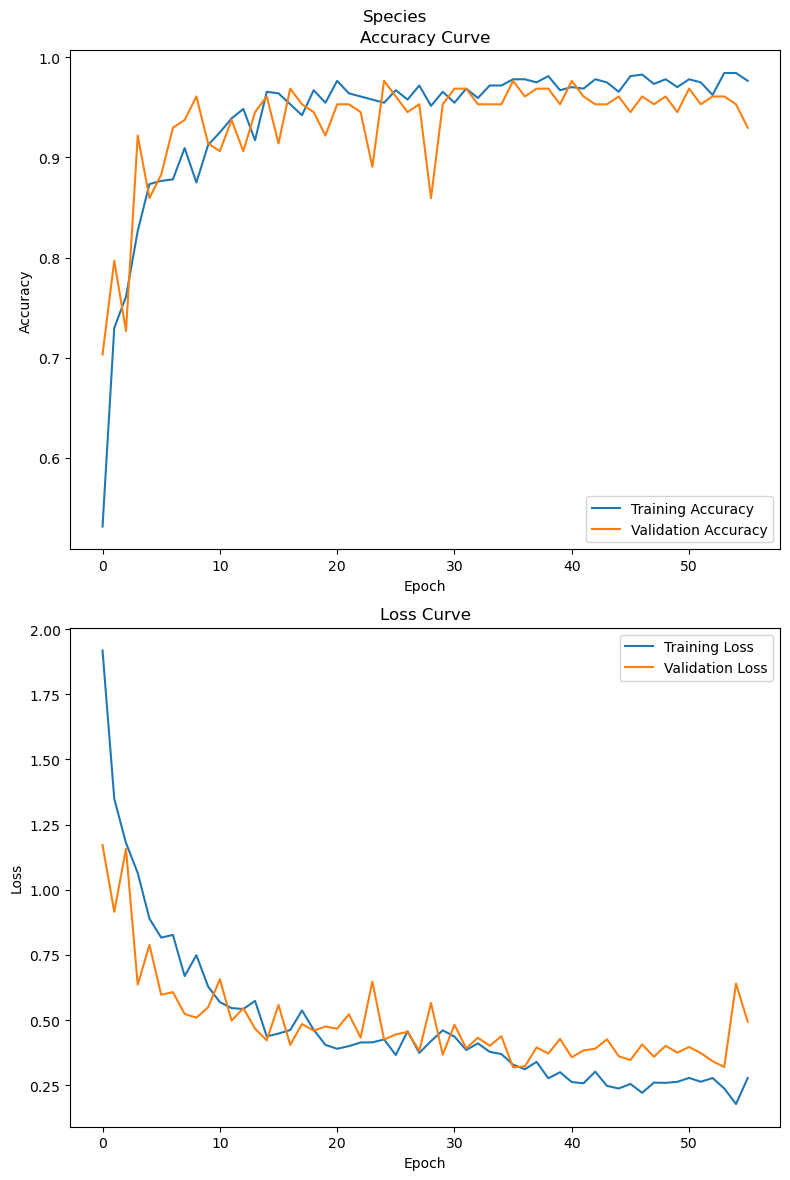

In [25]:
accuracy = history.history['species_output_accuracy']
val_accuracy = history.history['val_species_output_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Average species train accuracy:', np.mean(accuracy))
print('Average species Validation accuracy:', np.mean(val_accuracy))
print('Average species train loss:', np.mean(loss))
print('Average species Validation loss:', np.mean(val_loss))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
#accuracy
axes[0].plot(accuracy, label='Training Accuracy')
axes[0].plot(val_accuracy, label='Validation Accuracy')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

#loss
axes[1].plot(loss, label='Training Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.suptitle('Species')
plt.tight_layout()
plt.savefig('Species_combined.png')
plt.show()


Average freshness train accuracy: 0.8472098197255816
Average freshness Validation accuracy: 0.8327287946428571
Average freshness train loss: 0.47915723813431604
Average freshness Validation loss: 0.49134221619793345


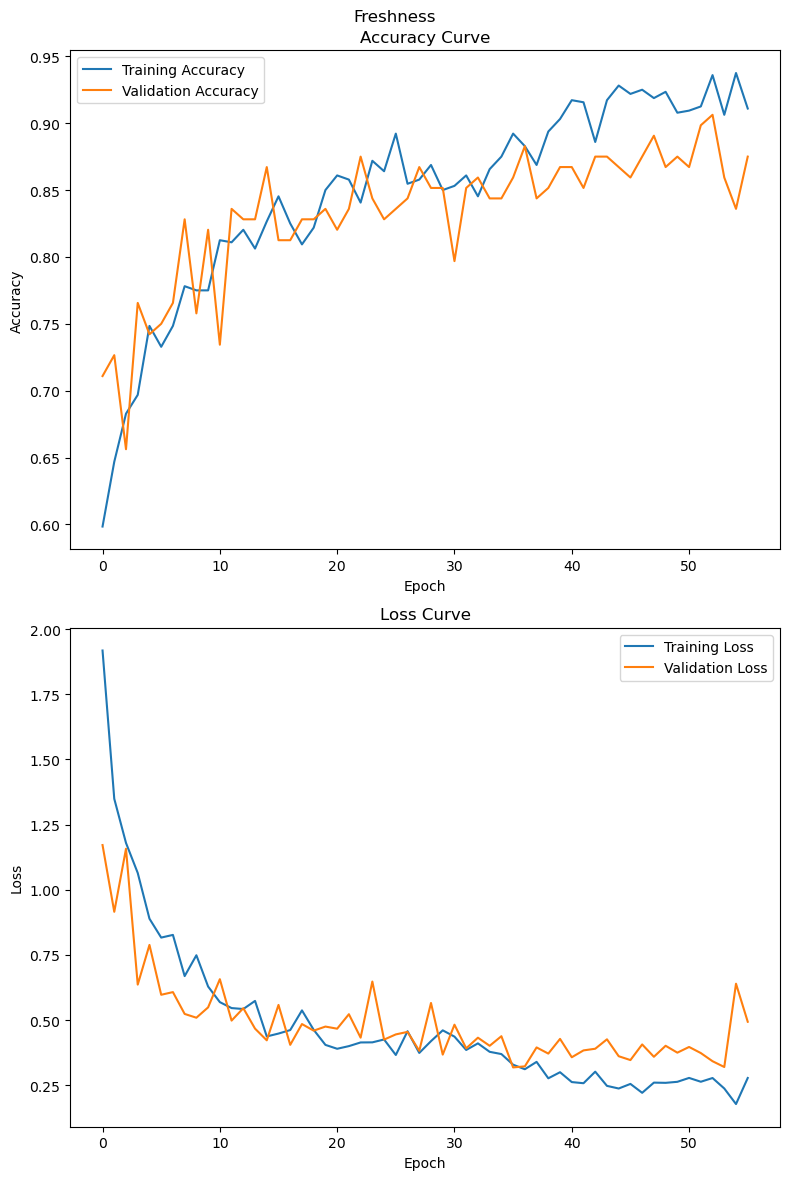

In [26]:
# Access the accuracy and loss values from the history object
accuracy = history.history['freshness_output_accuracy']
val_accuracy = history.history['val_freshness_output_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('Average freshness train accuracy:',np.mean(accuracy))
print('Average freshness Validation accuracy:',np.mean(val_accuracy))
print('Average freshness train loss:',np.mean(loss))
print('Average freshness Validation loss:',np.mean(val_loss))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
#accuracy
axes[0].plot(accuracy, label='Training Accuracy')
axes[0].plot(val_accuracy, label='Validation Accuracy')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

#loss
axes[1].plot(loss, label='Training Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.suptitle('Freshness')
plt.tight_layout()
plt.savefig('Freshness_combined.png')
plt.show()


In [27]:
model.save('final_model.h5')

In [28]:
os.getcwd()

'F:\\multi-task-model\\dataset'

In [29]:
res=model.predict(test_images)

1/1 [==============================] - 5s 5s/step


In [30]:
len(res[0]),len(res[1]),len(test_images)

(32, 32, 32)

In [31]:
def decode(result):
    predicted_species_labels = np.array(result[0])
    predicted_freshness_labels = np.array(result[1])

    # Inverse transform species labels
    predicted_species_labels_indices = np.argmax(predicted_species_labels, axis=1)
    predicted_species_labels_names = species_label_encoder.inverse_transform(predicted_species_labels_indices).tolist()

    # Inverse transform freshness labels
    predicted_freshness_labels_indices = np.argmax(predicted_freshness_labels, axis=1)
    predicted_freshness_labels_names = freshness_label_encoder.inverse_transform(predicted_freshness_labels_indices).tolist()

    return predicted_freshness_labels_names, predicted_species_labels_names

In [32]:
freshness,species=decode(res)

In [33]:
test_data['predicted_freshness']=freshness
test_data['predicted_species']=species

In [34]:
test_data

,image_paths,species,freshness,predicted_freshness,predicted_species
204,F:\multi-task-model\Sardine\Bad\20230526114041...,Sardine,Bad,Good,Sardine
208,F:\multi-task-model\Sardine\Bad\augmented_1_20...,Sardine,Bad,Bad,Sardine
532,F:\multi-task-model\Seer\Good\augmented_2_2023...,Seer,Good,Good,Seer
368,F:\multi-task-model\Sardine\Good\augmented__0_...,Sardine,Good,Good,Sardine
628,F:\multi-task-model\Tuna\Bad\augmented_3091.jpg,Tuna,Bad,Bad,Tuna
570,F:\multi-task-model\Seer\Good\augmented__0_290...,Seer,Good,Good,Seer
432,F:\multi-task-model\Seer\Bad\augmented_3_20230...,Seer,Bad,Bad,Seer
109,F:\multi-task-model\Mackerel\Good\202305261100...,Mackerel,Good,Bad,Mackerel
155,F:\multi-task-model\Mackerel\Good\augmented_4_...,Mackerel,Good,Bad,Tuna
483,F:\multi-task-model\Seer\Bad\augmented__0_5285...,Seer,Bad,Bad,Seer


In [35]:
metric_data=test_data.drop('image_paths',1)

C:\Users\KARTIK\AppData\Local\Temp\ipykernel_16552\1043400942.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  metric_data=test_data.drop('image_paths',1)


In [36]:
metric_data=metric_data.replace({'Good':1,'Bad':0, 'Mackerel':0,'Sardine':1,'Seer':2,'Tuna':3})

In [37]:
true_species = metric_data.species
pred_species = metric_data.predicted_species
true_freshness = metric_data.freshness
pred_freshness = metric_data.predicted_freshness

In [38]:
def generate_classification_report(true_labels, predicted_labels, labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    classification_rep = classification_report(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("\nClassification Report:")
    print(classification_rep)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    name = 'species' if len(labels) == 4 else 'freshness'
    plt.savefig(name+'_Confusion_matrix.png')
    plt.show()

Accuracy: 0.9375
Precision: 0.9356060606060607
Recall: 0.9375
F1-score: 0.9296536796536796

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00         9
           3       0.83      1.00      0.91         5

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.93        32
weighted avg       0.95      0.94      0.94        32



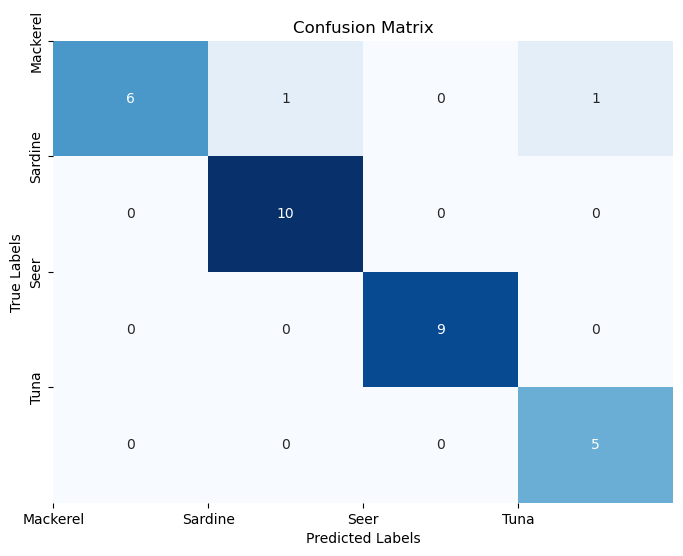

In [39]:
generate_classification_report(true_species,pred_species,['Mackerel','Sardine','Seer','Tuna'])

Accuracy: 0.78125
Precision: 0.7793522267206479
Recall: 0.7738095238095238
F1-score: 0.7757757757757758

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.77      0.71      0.74        14

    accuracy                           0.78        32
   macro avg       0.78      0.77      0.78        32
weighted avg       0.78      0.78      0.78        32



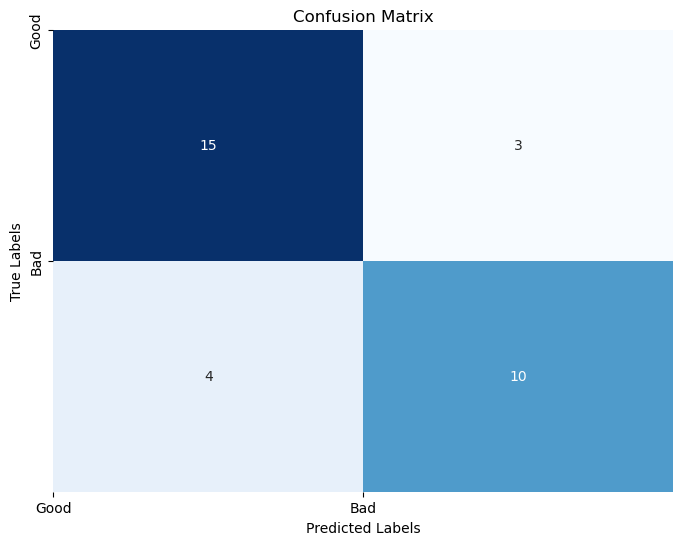

In [40]:
generate_classification_report(true_freshness,pred_freshness,['Good','Bad'])